In [2]:
import os
import cv2
import numpy as np
import glob
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

Labels are:  [0 1 2 4]  and the counts are:  [10649007    60415 75869435  1606734]


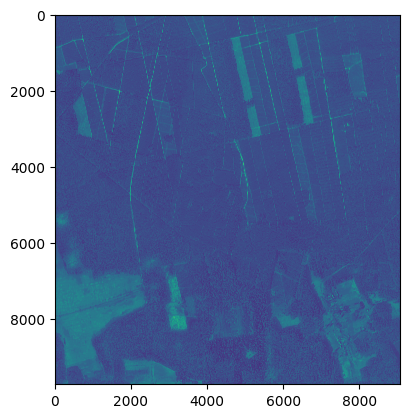

In [5]:
#Quick understanding of the dataset
temp_img = cv2.imread("images/M-33-7-A-d-2-3.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
temp_mask = cv2.imread("masks/M-33-7-A-d-2-3.tif") #3 channels but all same.
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)


In [6]:
#Now, crop each large image into patches of 256x256. Save them into a directory
#so we can use data augmentation and read directly from the drive.
root_directory = '/home/aayush/Downloads/landai/'

In [7]:
patch_size = 256

In [8]:
#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.
img_dir=root_directory+"images/"

In [10]:
for path, subdirs, files in os.walk(img_dir):
    # print(path,subdirs,files)
    dirname = path.split(os.path.sep)
    # #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    # print(images)
    for i, image_name in enumerate(images):
        if image_name.endswith(".tif"):
            # print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)

            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
            print(patches_img.shape)
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.

                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)


Now patchifying image: /home/aayush/Downloads/landai/images//N-34-106-A-b-3-4.tif
(37, 34, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//M-34-6-A-d-2-2.tif
(36, 34, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//N-34-97-C-b-1-2.tif
(18, 16, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//N-33-60-D-d-1-2.tif
(18, 16, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//M-34-51-C-d-4-1.tif
(36, 34, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//N-34-97-D-c-2-4.tif
(18, 16, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//N-33-139-D-c-1-3.tif
(37, 35, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//N-33-96-D-d-1-1.tif
(18, 16, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads/landai/images//M-34-65-D-d-4-1.tif
(36, 35, 1, 256, 256, 3)
Now patchifying image: /home/aayush/Downloads

In [11]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir=root_directory+"masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):
        if mask_name.endswith(".tif"):
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)

            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):

                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)


Now patchifying mask: /home/aayush/Downloads/landai/masks//N-34-106-A-b-3-4.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//M-34-6-A-d-2-2.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-34-97-C-b-1-2.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-33-60-D-d-1-2.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//M-34-51-C-d-4-1.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-34-97-D-c-2-4.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-33-139-D-c-1-3.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-33-96-D-d-1-1.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//M-34-65-D-d-4-1.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//M-34-56-A-b-1-4.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-33-130-A-d-3-3.tif
Now patchifying mask: /home/aayush/Downloads/landai/masks//N-34-94-A-b-2-4.tif
Now patchifying mask: /home/aayush/Downloads/landa

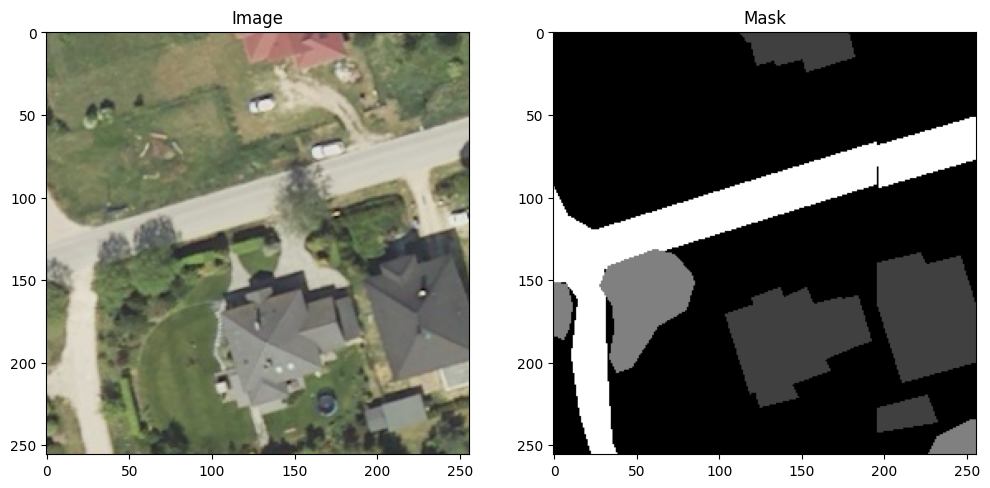

In [12]:
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [18]:
###########################################################################

#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0.

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)

    temp_image=cv2.imread(train_img_dir+img_list[img], 1)

    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)

    else:
        print("I am useless")
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Save Me
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
I am useless
Now preparing image and masks number:  10
I am useless
Now preparing image and masks number:  11
I am useless
Now preparing image and masks number:  12
I am useless
Now preparing image and masks number:  13
I am useless
Now preparing image and masks number:  14
I am useless
Now preparing image and masks number:  15
I am useless
Now preparing image and masks number:  16
I am useless
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing i

In [19]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [20]:
###############################################################
#Now split the data into training, validation and testing.

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators.

pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = '256_patches/images_with_useful_info/'
output_folder = 'data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################

#Now manually move folders around to bring them to the following structure.
"""
Your current directory structure:
Data/
    train/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....
    val/
        images/
            img1, img2, ...
        masks/
            msk1, msk2, ....

Copy the folders around to the following structure...


Data/
    train_images/
                train/
                    img1, img2, img3, ......

    train_masks/
                train/
                    msk1, msk, msk3, ......

    val_images/
                val/
                    img1, img2, img3, ......

    val_masks/
                val/
                    msk1, msk, msk3, ......


"""

'\nYour current directory structure:\nData/\n    train/\n        images/\n            img1, img2, ...\n        masks/\n            msk1, msk2, ....\n    val/\n        images/\n            img1, img2, ...\n        masks/\n            msk1, msk2, ....\n\nCopy the folders around to the following structure...\n\n\nData/\n    train_images/\n                train/\n                    img1, img2, img3, ......\n\n    train_masks/\n                train/\n                    msk1, msk, msk3, ......\n\n    val_images/\n                val/\n                    img1, img2, img3, ......\n\n    val_masks/\n                val/\n                    msk1, msk, msk3, ......\n\n\n'